In [5]:
import sys
import os
import numpy as np
import multiprocessing
import dill
import matplotlib.pyplot as plt
import pandas as pd

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src/simulations_v2")
from load_params import load_params

from multi_group_simulation import MultiGroupSimulation

In [35]:
def get_cum_hosp(df):
    return df[['severity_3', 'severity_2']].iloc[df.shape[0] - 1].sum()

def get_cum_outside_infections(df):
    return df['cumulative_outside_infections'].iloc[df.shape[0] - 1].sum()

def get_cum_infections(df):
    return df[['cumulative_mild', 'cumulative_severe']].iloc[df.shape[0] - 1].sum()

def get_cum_inf_trajectory(df):
    return np.sum(df[['cumulative_mild', 'cumulative_severe']], axis=1)

def get_cum_hosp_trajectory(df):
    return np.sum(df[['severity_3', 'severity_2']], axis=1)

def total_infections(list_sim_dfs):
    total = 0
    for sim_df in list_sim_dfs:
        total += get_cum_infections(sim_df)
    return total

def total_hosp(list_sim_dfs):
    total = 0
    for sim_df in list_sim_dfs:
        total += get_cum_hosp(sim_df)
    return total


In [17]:
# Fall Semester Group Config

# Loading group params
base_directory = '../src/simulations_v2/params/jan4calibration/'

ug_ga_params = load_params(base_directory + 'group_1_students_post_movein_private.yaml')[1]
ug_other_params = load_params(base_directory + 'group_2_students_post_movein_private.yaml')[1]
gs_params = load_params(base_directory + 'group_3_students_post_movein_private.yaml')[1]
fs_params = load_params(base_directory + 'faculty_staff_post_movein_private.yaml')[1]
#params_list = [ug_ga_params.copy(), ug_other_params.copy(), gs_params.copy(), fs_params.copy()]
params_list = [ug_ga_params.copy(), ug_other_params.copy(), gs_params.copy()]

In [19]:
# Scaling of the interaction matrix is wrong, made up number of f/s -> f/s contact
interaction_matrix = np.array([[161/125, 2/44, 0],
                              [8/125, 7/44, 0],
                              [0,0,1/15]])


# adding population size
params_list[0]['population_size'] = 3533
params_list[1]['population_size'] = 8434
params_list[2]['population_size'] = 6202
#params_list[3]['population_size'] = 10000

for idx in range(3):
    params_list[idx]['daily_outside_infection_p'] *= 2
    #params_list[idx]['test_protocol_QFNR'] = 0.25

# Making up initial ID prevalence
params_list[0]['initial_ID_prevalence'] = 1.95 * 2 / params_list[0]['population_size']
params_list[1]['initial_ID_prevalence'] = 2.34 * 2 / params_list[1]['population_size']
    
group_names = ['UG (Greek, Athlete)', 'UG (other)', 'GS']#, 'Faculty/Staff']

In [32]:
from multiprocessing import Process
import pickle


def get_trajectories(transmission_p, n, T=19*7):
    
    for idx in range(3):
        params_list[idx]['exposed_infection_p'] = transmission_p
    
    sim = MultiGroupSimulation(params_list, interaction_matrix, group_names)

    inf_trajectories = list()
    hosp_trajectories = list()
    
    for _ in range(n):
        sim.run_new_trajectory(T)
        group_results_inf = []
        group_results_hosp = []
        for group in sim.sims:
            df = group.sim_df
            group_results_inf.append(get_cum_infections(df))
            group_results_hosp.append(get_cum_hosp(df))
        inf_trajectories.append(group_results_inf)
        hosp_trajectories.append(group_results_hosp)

    return inf_trajectories, hosp_trajectories

def sim_target_f(transmission_p, ntrajectories, pickle_file_loc):
    results = get_trajectories(transmission_p, ntrajectories)
    pickle.dump(results, open(pickle_file_loc, "wb"))

def run_sims_new_process(transmission_p, ntrajectories, pickle_file_loc):
    p = Process(target = sim_target_f, args = (transmission_p, ntrajectories, pickle_file_loc))
    p.start()
    return p




In [33]:
base_transmission_p = 0.26
transmission_ps_to_try = [0.26 * x for x in np.arange(1,3.51, 0.1)]

output_dir = "jan_12_multigroup_sim_results/"
ntrajectories = 30

processes = []

for transmission_p in transmission_ps_to_try:
    filename = output_dir + "transmission_p_{}.pickle".format(transmission_p)
    p = run_sims_new_process(transmission_p, ntrajectories, filename)
    processes.append(p)
    
print("launched {} processes".format(len(processes)))
for p in processes:
    p.join()

launched 26 processes


In [51]:

def extract_sim_properties(fname):
    subname = fname.split('transmission_p_')[-1]
    subname = subname.split('.pickle')[0]
    return float(subname)

def load_sim_output(fname):
    with open(fname, "rb") as handle:
        sim_output = pickle.load(handle)
    return sim_output

def load_sim_outputs(sim_output_dir):
    sim_pickle_files = [sim_output_dir + '/' + file for  file in os.listdir(sim_output_dir) if '.pickle' in file]

    sim_outputs = {}
    for fname in sim_pickle_files:
        transmission_p = extract_sim_properties(fname)
        sim_output = load_sim_output(fname)
        sim_outputs[transmission_p] = sim_output

    print("Loaded {} simulation results".format(len(sim_outputs)))
    return sim_outputs

sim_outputs = load_sim_outputs('./jan_12_multigroup_sim_results/')

Loaded 26 simulation results


In [28]:
len(sim_outputs[0.26][0][0])

3

In [52]:
def get_avg_infxns_by_group(sim_output):
    infxns = sim_output[0]
    infxns_by_group = {idx:0 for idx in range(3)}
    for trajectory_data in infxns:
        for idx in range(3):
            infxns_by_group[idx] += trajectory_data[idx] / (len(infxns) * params_list[idx]['population_size'])
    return infxns_by_group


def get_avg_hosps_by_group(sim_output):
    infxns = sim_output[1]
    infxns_by_group = {idx:0 for idx in range(3)}
    for trajectory_data in infxns:
        for idx in range(3):
            infxns_by_group[idx] += trajectory_data[idx] / (len(infxns) * params_list[idx]['population_size'])
    return infxns_by_group


avg_infxns_by_transmission_p = {}
avg_hosps_by_transmission_p = {}
for t_p in sim_outputs:
    avg_infxns_by_transmission_p[t_p] = get_avg_infxns_by_group(sim_outputs[t_p])
    avg_hosps_by_transmission_p[t_p] = get_avg_hosps_by_group(sim_outputs[t_p])

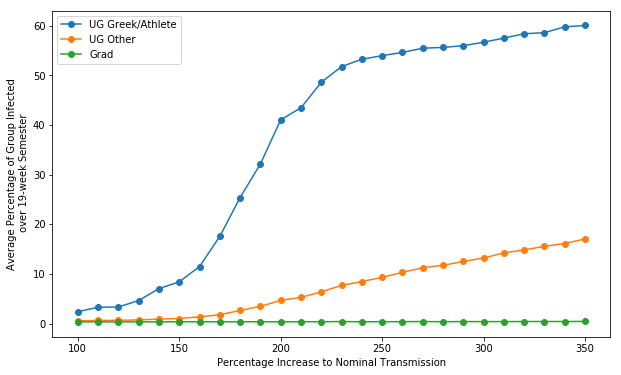

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline

group_labels={0: 'UG Greek/Athlete', 1:'UG Other', 2:'Grad'}

plt.figure(figsize=(10,6))
for groupidx in range(3):
    group_infxns = []
    for t_p in transmission_ps_to_try:
        group_infxns.append(avg_infxns_by_transmission_p[t_p][groupidx] * 100)
    plt.plot([100 * t_p / 0.26 for t_p in transmission_ps_to_try], 
             group_infxns, marker='o', label=group_labels[groupidx])
plt.legend(loc='best')
plt.xlabel('Percentage Increase to Nominal Transmission')
plt.ylabel('Average Percentage of Group Infected\n over 19-week Semester')
plt.show()

# use 3/7 surveillance testing

In [48]:
base_transmission_p = 0.26
transmission_ps_to_try = [0.26 * x for x in np.arange(1,3.51, 0.1)]

output_dir = "jan_12_multigroup_sim_results_higher_surveillance/"
params_list[0]['test_population_fraction'] *= 1.5
ntrajectories = 30

processes = []

for transmission_p in transmission_ps_to_try:
    filename = output_dir + "transmission_p_{}.pickle".format(transmission_p)
    p = run_sims_new_process(transmission_p, ntrajectories, filename)
    processes.append(p)
    
print("launched {} processes".format(len(processes)))
for p in processes:
    p.join()

launched 26 processes


Loaded 26 simulation results


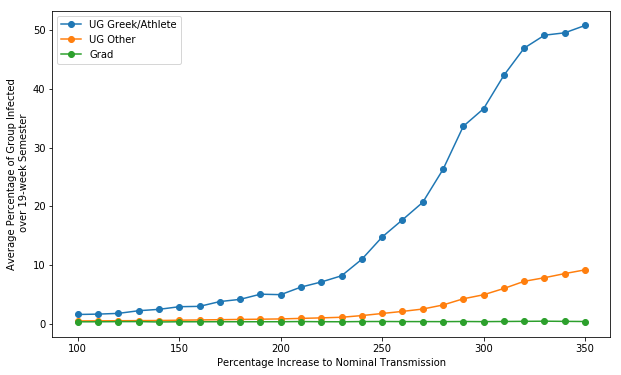

In [54]:
sim_outputs = load_sim_outputs('./jan_12_multigroup_sim_results_higher_surveillance/')
avg_infxns_by_transmission_p = {}
avg_hosps_by_transmission_p = {}
for t_p in sim_outputs:
    avg_infxns_by_transmission_p[t_p] = get_avg_infxns_by_group(sim_outputs[t_p])
    avg_hosps_by_transmission_p[t_p] = get_avg_hosps_by_group(sim_outputs[t_p])
plt.figure(figsize=(10,6))
for groupidx in range(3):
    group_infxns = []
    for t_p in transmission_ps_to_try:
        group_infxns.append(avg_infxns_by_transmission_p[t_p][groupidx] * 100)
    plt.plot([100 * t_p / 0.26 for t_p in transmission_ps_to_try], 
             group_infxns, marker='o', label=group_labels[groupidx])
plt.legend(loc='best')
plt.xlabel('Percentage Increase to Nominal Transmission')
plt.ylabel('Average Percentage of Group Infected\n over 19-week Semester')
plt.show()